In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import talib
import seaborn as sns

In [2]:
os.getcwd()

'/Users/yangxiang/A List/Investment/Stock Prediction Project'

In [3]:
df=pd.read_csv('/Users/yangxiang/A List/Investment/Data/MSFT_StockPrice.csv')

In [4]:
print(df.head())

         Date      Open      High       Low     Close  Adj Close      Volume
0  1986-03-13  0.088542  0.101563  0.088542  0.097222   0.062055  1031788800
1  1986-03-14  0.097222  0.102431  0.097222  0.100694   0.064271   308160000
2  1986-03-17  0.100694  0.103299  0.100694  0.102431   0.065379   133171200
3  1986-03-18  0.102431  0.103299  0.098958  0.099826   0.063717    67766400
4  1986-03-19  0.099826  0.100694  0.097222  0.098090   0.062609    47894400


In [5]:
#Set the time as the index
# convert to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.info()
# set the index
df.set_index('Date', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8688 entries, 0 to 8687
Data columns (total 7 columns):
Date         8688 non-null datetime64[ns]
Open         8688 non-null float64
High         8688 non-null float64
Low          8688 non-null float64
Close        8688 non-null float64
Adj Close    8688 non-null float64
Volume       8688 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 475.2 KB


In [6]:
# Rename the Adj_Close column
df=df.rename(columns={"Adj Close": "Adj_Close"})

# EDA on Microsoft stock data

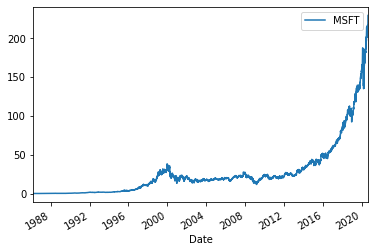

In [7]:
df['Adj_Close'].plot(label='MSFT', legend=True)
plt.show()

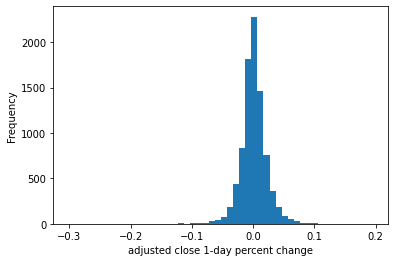

In [8]:
# Histogram of the daily price change percent of Adj_Close for MSFT
df['Adj_Close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

# A Right skewed nearly normal distribution for stock

In [9]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
df['5d_future_close'] = df['Adj_Close'].shift(-5)
df['5d_close_future_pct'] = df['5d_future_close'].pct_change(5)
df['5d_close_pct'] = df['Adj_Close'].pct_change(5)

In [10]:
# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000            -0.048308
5d_close_future_pct     -0.048308             1.000000


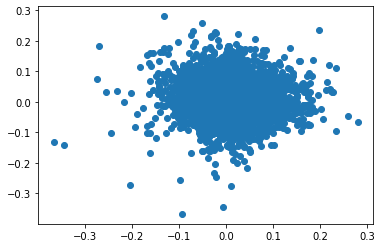

In [11]:
# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(df['5d_close_pct'], df['5d_close_future_pct'])
plt.show()


#What we should see:
#We can see the 5-day change is slightly negatively correlated to the change in the last 5 days -- 
#an example of overall mean reversion

#What we actually see:
# not so much correlated

# Data Preparation


###### We want to add historical data to our machine learning models to make better predictions, but adding lots of historical time steps is tricky. Instead, we can condense information from previous points into a single timestep with indicators.
* Moving Average 
* RSI(Relative Strength index)RSI: when it close to 0: The price is due to rebound from recent lows, close to 100: stock is due to deline. A common period for RSI is 14

### Feature Engineering

In [12]:
# Create moving average and RSI features


feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:

    # Create the moving average indicator and divide by Adj_Close
    df['ma' + str(n)] = talib.SMA(df['Adj_Close'].values,
                              timeperiod=n) / df['Adj_Close']
    # Create the RSI indicator
    df['rsi' + str(n)] = talib.RSI(df['Adj_Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]
    
print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


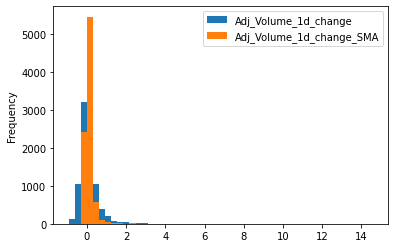

In [13]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
df['Adj_Volume_1d_change'] = df['Volume'].pct_change()
df['Adj_Volume_1d_change_SMA'] = talib.SMA(df['Adj_Volume_1d_change'].values,
                                               timeperiod=5)

# Plot histogram of volume % change data
df[new_features].plot(kind='hist', sharex=False, bins=50)
plt.show()

# We can see the moving average of volume changes has a much smaller range than the raw data.

In [14]:
#Create day-of-week features

# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(df.index.dayofweek,
                              prefix='weekday',
                              drop_first=True)
# Drop the monday column since it can be told by looking at other 4 columns 

# Set the index as the original DataFrame index for merging
days_of_week.index = df.index

# Join the dataframe with the days of week DataFrame
df = pd.concat([df, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
df.dropna(inplace=True)  # drop missing values in-place
df.head()


,Open,High,Low,Close,Adj_Close,Volume,5d_future_close,5d_close_future_pct,5d_close_pct,ma14,...,ma50,rsi50,ma200,rsi200,Adj_Volume_1d_change,Adj_Volume_1d_change_SMA,weekday_1,weekday_2,weekday_3,weekday_4
Date,,,,,,,,,,,,,,,,,,,,,
1986-12-26,0.171441,0.172743,0.171007,0.171007,0.109150,3715200,0.111921,0.025387,0.039573,0.977704,...,0.899901,63.388870,0.684038,58.817340,-0.471311,0.382481,0,0,0,1
1986-12-29,0.171007,0.172743,0.164063,0.164063,0.104718,41702400,0.113583,0.084656,-0.025770,1.017194,...,0.943173,59.998503,0.714920,57.852421,10.224806,1.734260,0,0,0,0
1986-12-30,0.164063,0.166667,0.162326,0.165799,0.105826,25401600,0.119678,0.130894,-0.025507,1.005796,...,0.938220,60.536944,0.709345,58.025438,-0.390884,1.791350,1,0,0,0
1986-12-31,0.165799,0.170139,0.165799,0.167535,0.106934,23356800,0.123556,0.155442,-0.025250,0.994819,...,0.933472,61.071634,0.704016,58.197899,-0.080499,1.715502,0,1,0,0
1987-01-02,0.167535,0.169271,0.164931,0.165799,0.105826,12643200,0.128543,0.214664,-0.032908,1.003365,...,0.947434,60.238794,0.713429,57.958567,-0.458693,1.764684,0,0,0,1


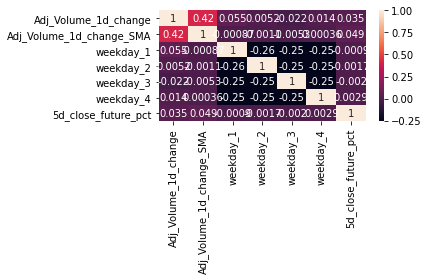

In [15]:
# Examine correlations of the new features
# Add the weekday labels to the new_features list
new_features.extend(['weekday_' + str(i) for i in range(1, 5)])

# Plot the correlations between the new features and the targets
sns.heatmap(df[new_features + ['5d_close_future_pct']].corr(), annot=True)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()


# Even though the correlations are weak, they may improve our predictions via interactions with other features.

In [16]:
df

,Open,High,Low,Close,Adj_Close,Volume,5d_future_close,5d_close_future_pct,5d_close_pct,ma14,...,ma50,rsi50,ma200,rsi200,Adj_Volume_1d_change,Adj_Volume_1d_change_SMA,weekday_1,weekday_2,weekday_3,weekday_4
Date,,,,,,,,,,,,,,,,,,,,,
1986-12-26,0.171441,0.172743,0.171007,0.171007,0.109150,3715200,0.111921,0.025387,0.039573,0.977704,...,0.899901,63.388870,0.684038,58.817340,-0.471311,0.382481,0,0,0,1
1986-12-29,0.171007,0.172743,0.164063,0.164063,0.104718,41702400,0.113583,0.084656,-0.025770,1.017194,...,0.943173,59.998503,0.714920,57.852421,10.224806,1.734260,0,0,0,0
1986-12-30,0.164063,0.166667,0.162326,0.165799,0.105826,25401600,0.119678,0.130894,-0.025507,1.005796,...,0.938220,60.536944,0.709345,58.025438,-0.390884,1.791350,1,0,0,0
1986-12-31,0.165799,0.170139,0.165799,0.167535,0.106934,23356800,0.123556,0.155442,-0.025250,0.994819,...,0.933472,61.071634,0.704016,58.197899,-0.080499,1.715502,0,1,0,0
1987-01-02,0.167535,0.169271,0.164931,0.165799,0.105826,12643200,0.128543,0.214664,-0.032908,1.003365,...,0.947434,60.238794,0.713429,57.958567,-0.458693,1.764684,0,0,0,1
1987-01-05,0.165799,0.177083,0.164931,0.175347,0.111921,48499200,0.136854,0.222773,0.025387,0.953321,...,0.900888,63.065993,0.676854,58.893149,2.835991,2.426144,0,0,0,0
1987-01-06,0.175347,0.178819,0.174479,0.177951,0.113583,40032000,0.132975,0.170730,0.084656,0.946688,...,0.892975,63.782542,0.669341,59.142064,-0.174584,0.346266,1,0,0,0
1987-01-07,0.177951,0.187500,0.177951,0.187500,0.119678,60998400,0.132975,0.111106,0.130894,0.908396,...,0.853608,66.233955,0.637845,60.034026,0.523741,0.529191,0,1,0,0
1987-01-08,0.188368,0.195313,0.188368,0.193576,0.123556,61488000,0.140178,0.134530,0.155442,0.891095,...,0.832915,67.655332,0.620448,60.584263,0.008026,0.546896,0,0,1,0


In [17]:
# Create features and targets


# Drop all na values
df = df.dropna()

# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = df[feature_names]
targets = df['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = df[feature_and_target_cols]

In [18]:
feat_targ_df=feat_targ_df.drop(columns=['5d_close_future_pct'])

### Split the train test data for the timer serise data( different than traditional ML model split)

In [24]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm


# Create a size for the training set that is 80% of the total number of samples
train_size = int(0.80 * features.shape[0])
train_features = feat_targ_df[:train_size]
train_targets = targets[:train_size]
test_features = feat_targ_df[train_size:]
test_targets = targets[train_size:]
print(feat_targ_df.shape, train_features.shape, test_features.shape)

(8483, 15) (6786, 15) (1697, 15)


In [25]:
train_targets.shape

(6786,)

In [26]:
test_targets.shape

(1697,)

In [27]:
# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)



                          5d_close_pct      ma14     rsi14      ma30  \
5d_close_pct                  1.000000 -0.838936  0.633535 -0.638338   
ma14                         -0.838936  1.000000 -0.783048  0.859831   
rsi14                         0.633535 -0.783048  1.000000 -0.865435   
ma30                         -0.638338  0.859831 -0.865435  1.000000   
rsi30                         0.487845 -0.642940  0.931200 -0.806797   
ma50                         -0.506948  0.705799 -0.840766  0.922963   
rsi50                         0.402709 -0.545378  0.830315 -0.722245   
ma200                        -0.281295  0.402028 -0.553208  0.573831   
rsi200                        0.241724 -0.334626  0.529180 -0.475954   
Adj_Volume_1d_change         -0.033961  0.042393 -0.021622  0.023655   
Adj_Volume_1d_change_SMA     -0.073280  0.079860 -0.039763  0.047772   
weekday_1                    -0.001371  0.003136 -0.001379  0.002325   
weekday_2                     0.003063 -0.009610  0.005930 -0.00

/Users/yangxiang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  after removing the cwd from sys.path.


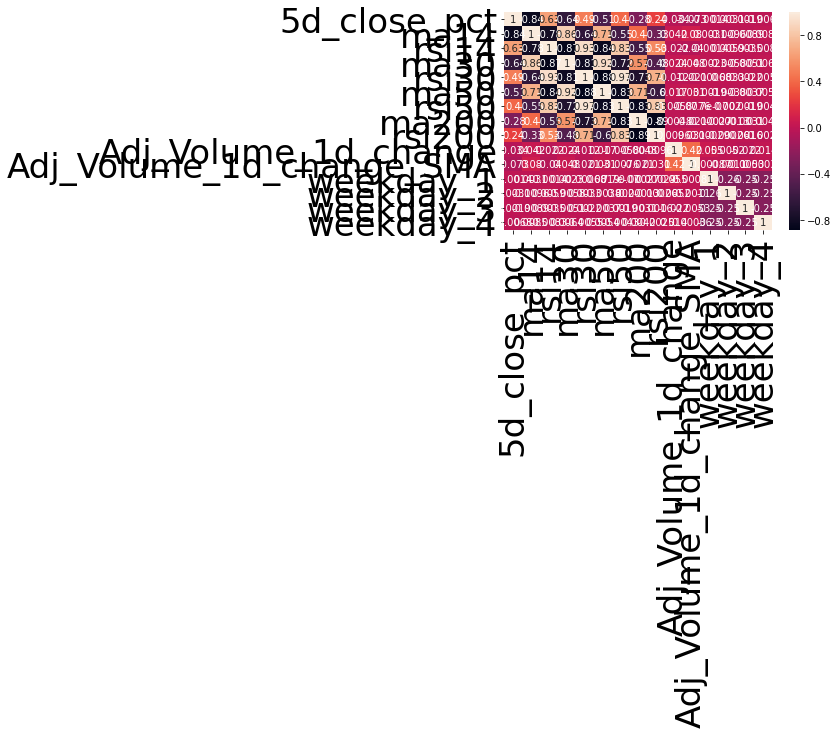

In [28]:
# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True, annot_kws = {"size": 10})
plt.yticks(rotation=0, size = 34); plt.xticks(rotation=90, size = 34)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

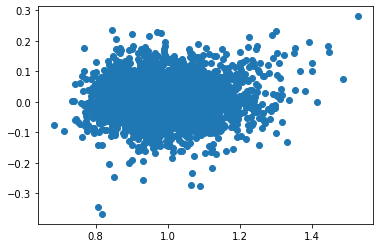

In [29]:
# Inspect the heatmap that you generated in the previous step. 
#ma50 exhibits the highest correlation with the target (5d_close_future_pct)

# Create a scatter plot of the most highly correlated variable with the target
plt.scatter(df['ma50'], df['5d_close_future_pct'])
plt.show()
# we cam see a little positive correlated


# Machine Learning Model


In [30]:
X_train=train_features

In [31]:
y_train=train_targets

In [32]:
X_test=test_features

In [33]:
y_test=test_targets

## Start with Random Forest 

In [51]:
#a) Use the RandomForestClassifier in sklearn. 
#Fit your model on the training data & make sure to add a random_state
from sklearn.ensemble import RandomForestRegressor
rnd_clf = RandomForestRegressor(random_state=42)
rnd_clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [57]:
# Look at the R^2 scores on train and test
print(rnd_clf.score(train_features, train_targets))
print(rnd_clf.score(test_features, test_targets))

0.8877356339721826
-0.2189991223308696


In [53]:
# Use the fitted model to predict on test data. 
y_pred_rf = rnd_clf.predict(X_test)

In [81]:

# a) Use the RandomForestClassifier along with the GridSearchCV tool
from sklearn.model_selection import GridSearchCV
#create a dictionary of parameters 
param_grid = {'n_estimators':[50, 100, 500],
'max_features': [2, 4, 6],
'max_depth':[6, 8, 10, 12]}

# create Random Forest model 
rf_obj=RandomForestRegressor()

# Create gridsearch object with various combinations of parameters
rf_Grid = GridSearchCV(rf_obj, param_grid, cv = 5,refit = True, n_jobs=-1, verbose = 5)
# Fit the GridSearch
rf_Grid.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [82]:
#Identify the best performing model:
rf_Grid.best_params_

{'max_depth': 6, 'max_features': 2, 'n_estimators': 500}

In [83]:
best_model=rf_Grid.best_estimator_

In [84]:
best_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [85]:
#c) Use the best estimator model to predict on test data.
y_pred_rf_Grid = best_model.predict(X_test)

In [23]:
# Look at the R^2 scores on train and test
rnd_clf = best_model
rnd_clf.fit(X_train, y_train)
print(rnd_clf.score(train_features, train_targets))
print(rnd_clf.score(test_features, test_targets))

NameError: name 'best_model' is not defined

# Create a feature importance plot for the best performing Random Forest model



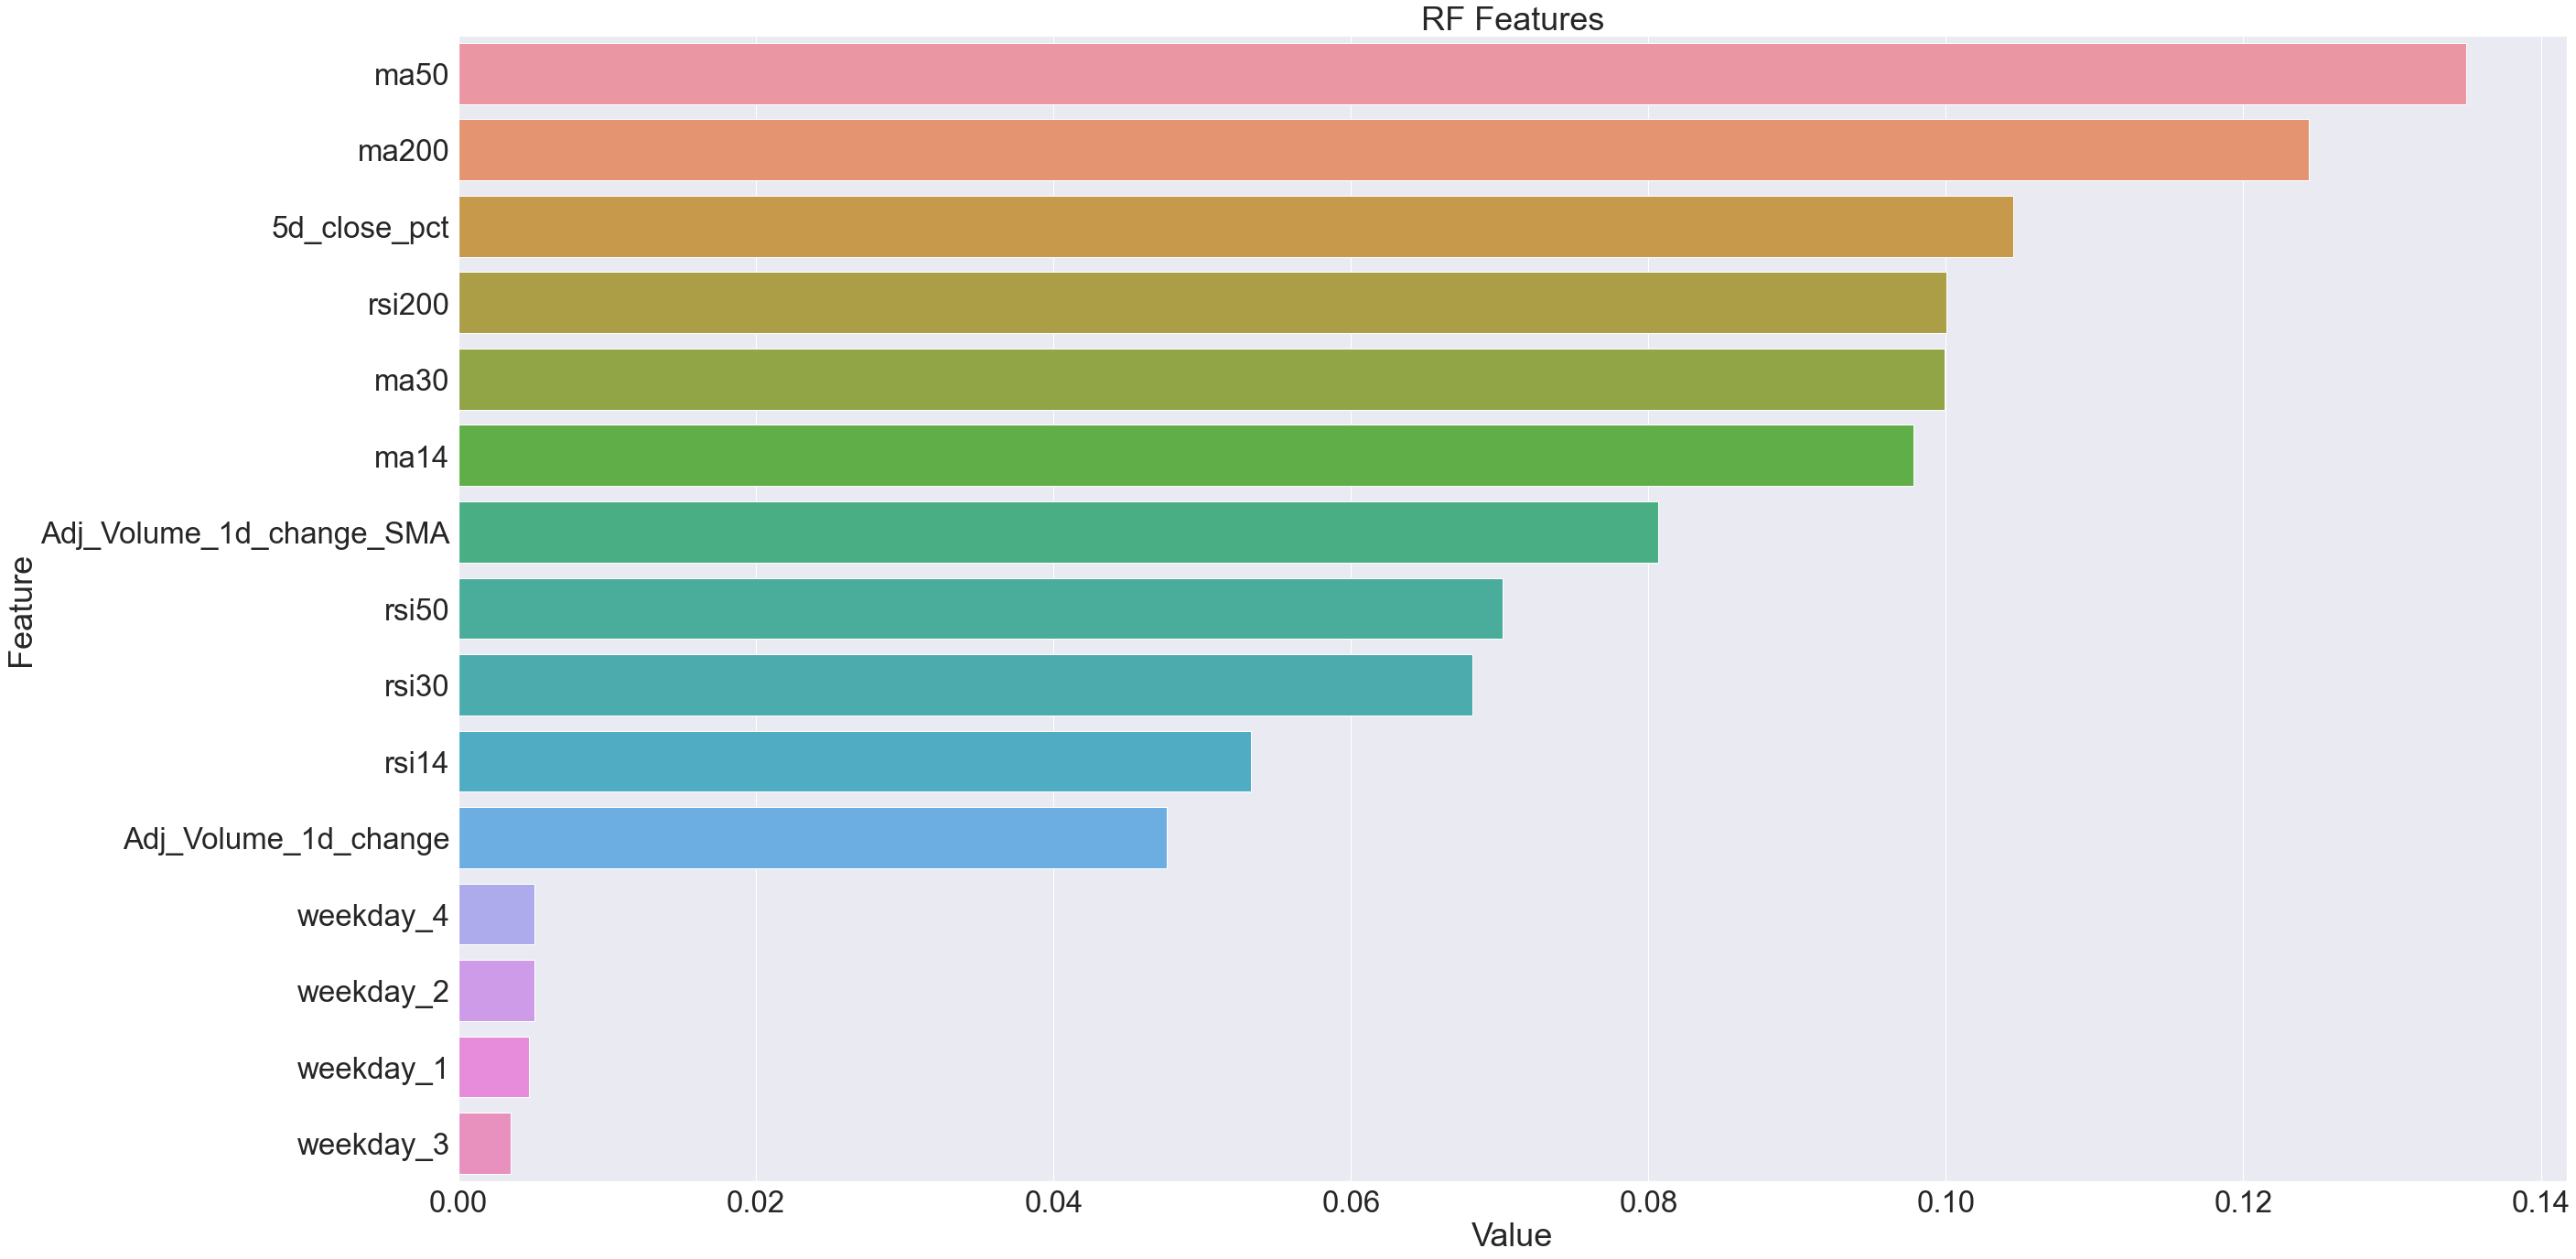

In [90]:
# What are the top 5 features for this model?
import matplotlib.pyplot as plt
import seaborn as sns
feature_imp = pd.DataFrame({'Value':rnd_clf.feature_importances_,'Feature':X_train.columns})
plt.figure(figsize=(40, 20))
sns.set(font_scale = 3)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:50])
plt.title('RF Features')
plt.tight_layout()
plt.show()

# Try XGBoosting

In [49]:
#a) Use XGBClassifier along with the RandomizedSearchCV tool. Run the RandomizedSearchCV 

# RandomizedSearchCV:In contrast to GridSearchCV, not all parameter values are tried out, 
#but rather a fixed number of parameter settings is sampled from the specified distributions. 

#The number of parameter settings that are tried is given by n_iter.
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
#create a dictionary of parameters 
param_grid = {'n_estimators':list(range(100,1050,50)),
'learning_rate': [x * 0.1 for x in range(1, 17)],
'max_depth':[ 2,3],
'gamma':[x * 0.25 for x in range(0, 21)]}

# create XGB model 
XGB_obj=XGBRegressor()

# Create gridsearch object with various combinations of parameters
XGB_RandomizedSearch = RandomizedSearchCV(XGB_obj, param_grid, cv = 5,refit = True, n_jobs=-1, verbose = 5)
# Fit the GridSearch
XGB_RandomizedSearch.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   57.8s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                        'learning_rate': [0.1, 0.2,
                                                          0.30000000000000004,
                                           

In [50]:
#se the best estimator from RandomizedSearch to predict on test data.
# Identify the best performing model:
XGB_RandomizedSearch.best_params_

{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 1.5, 'gamma': 1.75}

In [51]:
best_model_XGB=XGB_RandomizedSearch.best_estimator_


In [52]:
# Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.

y_pred_XGB_RandomizedSearch = best_model_XGB.predict(X_test)

In [53]:
y_pred_XGB_RandomizedSearch

array([0.0053809, 0.0053809, 0.0053809, ..., 0.0053809, 0.0053809,
       0.0053809], dtype=float32)

/Users/yangxiang/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:695: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


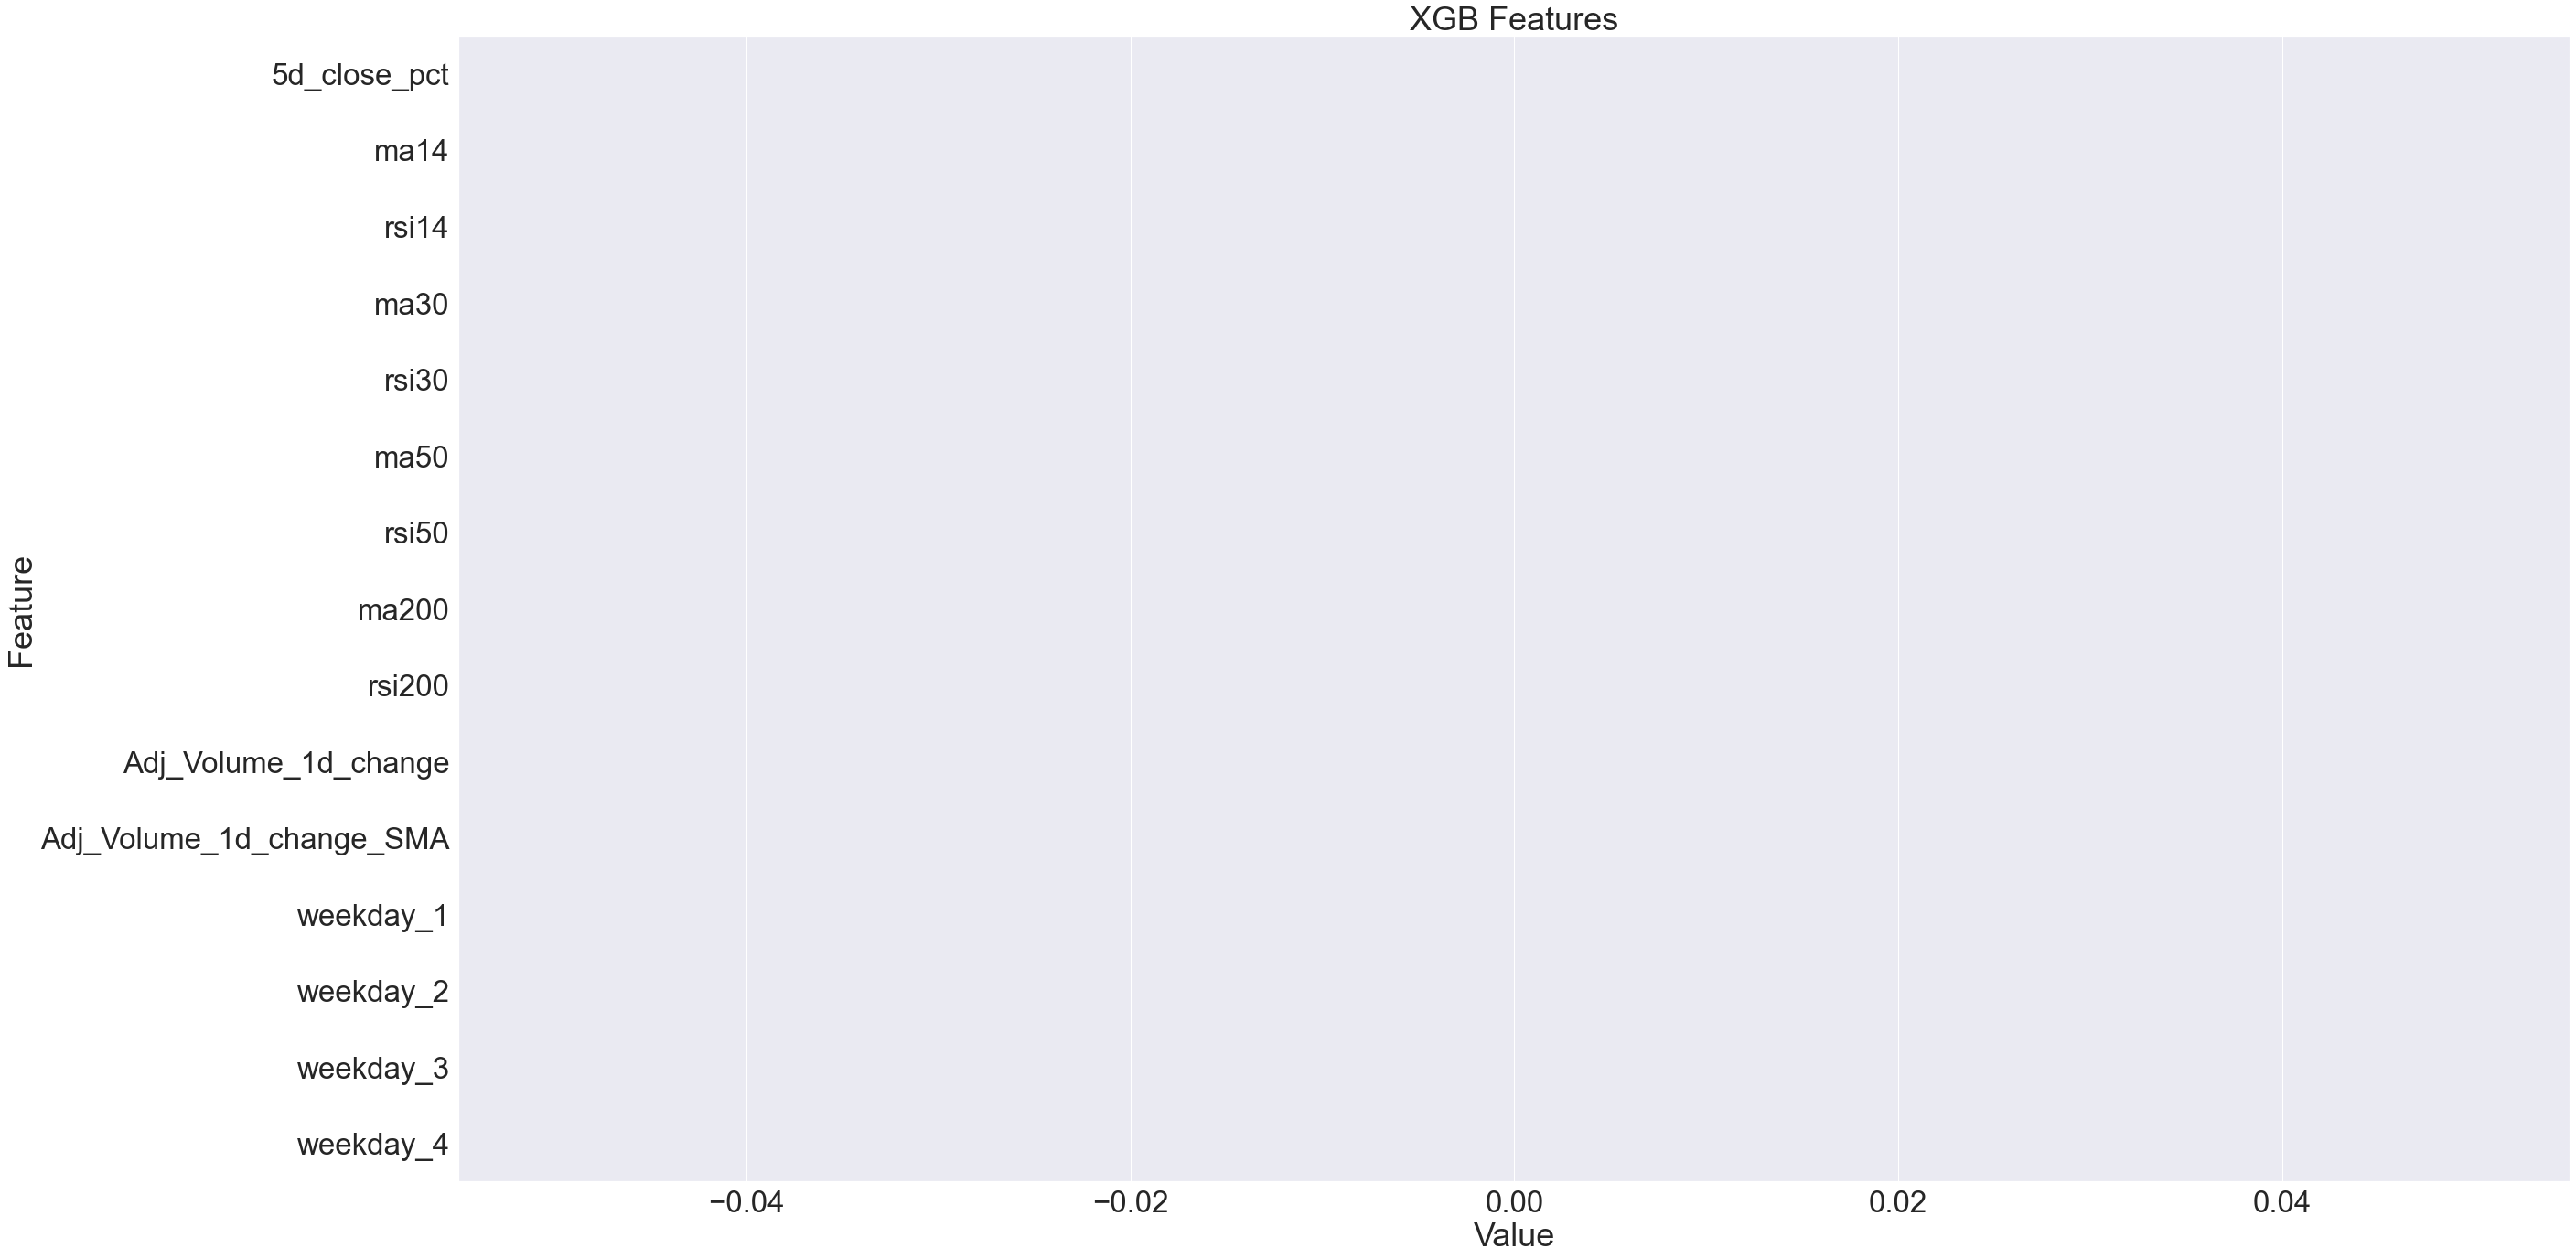

In [47]:
# Identify the top 5 features. Feel free to print a list OR to make a plot.

import matplotlib.pyplot as plt
import seaborn as sns
feature_imp = pd.DataFrame({'Value':best_model_XGB.feature_importances_,'Feature':X_train.columns})
plt.figure(figsize=(40, 20))
sns.set(font_scale = 3)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:50])
plt.title('XGB Features')
plt.tight_layout()
plt.show()

# Try KNN regression

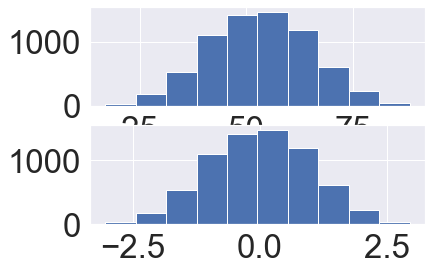

In [58]:
# Used the standarized data is necessar
from sklearn.preprocessing import scale

# Remove unimportant features (weekdays)
train_features = train_features.iloc[:, :-4]
test_features = test_features.iloc[:, :-4]

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

In [59]:
# Optimize n_neighbors


Now that we have scaled data, we can try using a KNN model. To maximize performance, we should tune our model's hyperparameters. For the k-nearest neighbors algorithm, we only have one hyperparameter: n, the number of neighbors. We set this hyperparameter when we create the model with KNeighborsRegressor. The argument for the number of neighbors is n_neighbors.

In [62]:
from sklearn.neighbors import KNeighborsRegressor

for n in range(2, 20):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)
    print('train, test scores')
    print(knn.score(scaled_train_features, train_targets))
    print(knn.score(scaled_test_features, test_targets))
    print()  # prints a blank line

n_neighbors = 2
train, test scores
0.6704652651618432
-1.0736686200889198

n_neighbors = 3
train, test scores
0.5175518507593508
-0.8098050534019037

n_neighbors = 4
train, test scores
0.4340236828011661
-0.608742462280472

n_neighbors = 5
train, test scores
0.37739908367077746
-0.49163629936065334

n_neighbors = 6
train, test scores
0.3336544261776003
-0.4220338669436676

n_neighbors = 7
train, test scores
0.30089977406494783
-0.3578534168125281

n_neighbors = 8
train, test scores
0.2727235750224959
-0.30773242551762925

n_neighbors = 9
train, test scores
0.2460743339305015
-0.2786217029466669

n_neighbors = 10
train, test scores
0.22819796633112577
-0.24533050811327195

n_neighbors = 11
train, test scores
0.21005784096932867
-0.21322119986513455

n_neighbors = 12
train, test scores
0.19859221080181833
-0.19717729654716343

n_neighbors = 13
train, test scores
0.1868238187667528
-0.1801976367695306

n_neighbors = 14
train, test scores
0.17663535477167314
-0.16608777200402636

n_neighbo

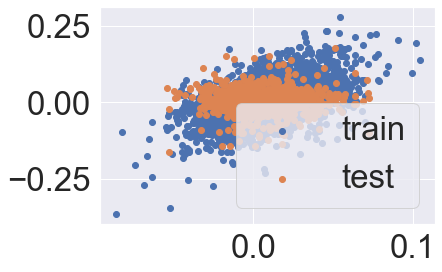

In [69]:
# Create the model with the best-performing n_neighbors of 5
knn = KNeighborsRegressor(n_neighbors=9)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.legend()
plt.show()



# it looks like the model is not that accurate

# Neuro Networks

In [71]:
from keras.models import Sequential
from keras.layers import Dense

# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=25)

Using TensorFlow backend.


Epoch 1/25
6786/6786 [==============================] - 0s 62us/step - loss: 0.0092
Epoch 2/25
6786/6786 [==============================] - 0s 36us/step - loss: 0.0032
Epoch 3/25
6786/6786 [==============================] - 0s 36us/step - loss: 0.0028
Epoch 4/25
6786/6786 [==============================] - 0s 35us/step - loss: 0.0026
Epoch 5/25
6786/6786 [==============================] - 0s 36us/step - loss: 0.0025
Epoch 6/25
6786/6786 [==============================] - 0s 35us/step - loss: 0.0024
Epoch 7/25
6786/6786 [==============================] - 0s 36us/step - loss: 0.0023
Epoch 8/25
6786/6786 [==============================] - 0s 36us/step - loss: 0.0023
Epoch 9/25
6786/6786 [==============================] - 0s 36us/step - loss: 0.0023
Epoch 10/25
6786/6786 [==============================] - 0s 62us/step - loss: 0.0023: 0s - loss: 0.
Epoch 11/25
6786/6786 [==============================] - 0s 50us/step - loss: 0.0023
Epoch 12/25
6786/6786 [==============================] - 0s

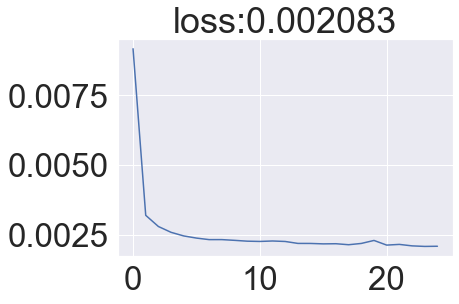

In [72]:
# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

0.10357041085405205
-0.5124149599072167


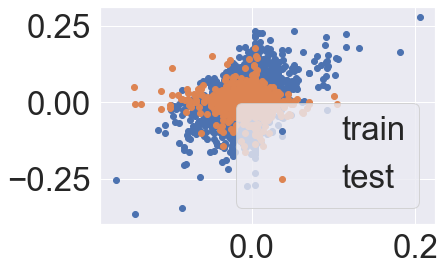

In [73]:
from sklearn.metrics import r2_score

# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend()
plt.show()

Custom loss function : with stock price prediction it can be useful to implement a custom loss function. A custom loss function can help improve our model's performance in specific ways we choose. For example, we're going to create a custom loss function with a large penalty for predicting price movements in the wrong direction. This will help our net learn to at least predict price movements in the correct direction.


In [77]:
# Custom loss function
import keras.losses
import tensorflow as tf

# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)


<function sign_penalty at 0x7fe6525acd90>


Epoch 1/25
6786/6786 [==============================] - 1s 82us/step - loss: 0.4586
Epoch 2/25
6786/6786 [==============================] - 0s 51us/step - loss: 0.2228
Epoch 3/25
6786/6786 [==============================] - 0s 36us/step - loss: 0.1928
Epoch 4/25
6786/6786 [==============================] - 0s 50us/step - loss: 0.1651
Epoch 5/25
6786/6786 [==============================] - 0s 44us/step - loss: 0.1589
Epoch 6/25
6786/6786 [==============================] - 0s 41us/step - loss: 0.1408
Epoch 7/25
6786/6786 [==============================] - 0s 47us/step - loss: 0.1277
Epoch 8/25
6786/6786 [==============================] - 0s 44us/step - loss: 0.1211
Epoch 9/25
6786/6786 [==============================] - 0s 42us/step - loss: 0.1164
Epoch 10/25
6786/6786 [==============================] - 1s 74us/step - loss: 0.1894
Epoch 11/25
6786/6786 [==============================] - 1s 99us/step - loss: 0.1191: 0s - loss: 0
Epoch 12/25
6786/6786 [==============================] - 0s 

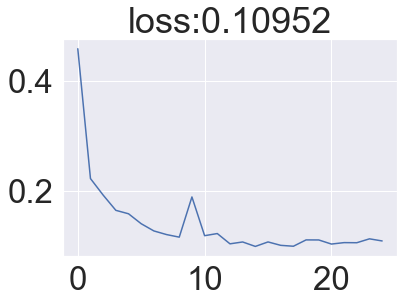

In [78]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

-0.005311160311151308
-0.0394835902058448


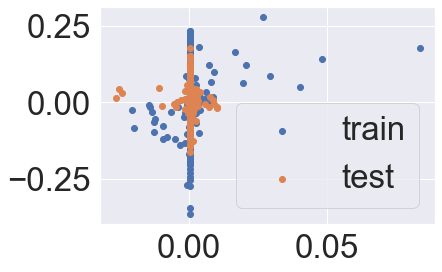

In [79]:
# Evaluate R^2 scores
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')  # plot test set
plt.legend(); plt.show()

Epoch 1/25
6786/6786 [==============================] - 0s 67us/step - loss: 0.0140
Epoch 2/25
6786/6786 [==============================] - 0s 49us/step - loss: 0.0047
Epoch 3/25
6786/6786 [==============================] - 0s 50us/step - loss: 0.0032
Epoch 4/25
6786/6786 [==============================] - 0s 51us/step - loss: 0.0027
Epoch 5/25
6786/6786 [==============================] - 0s 40us/step - loss: 0.0029
Epoch 6/25
6786/6786 [==============================] - 0s 39us/step - loss: 0.0024
Epoch 7/25
6786/6786 [==============================] - 0s 44us/step - loss: 0.0024
Epoch 8/25
6786/6786 [==============================] - 0s 41us/step - loss: 0.0024
Epoch 9/25
6786/6786 [==============================] - 0s 50us/step - loss: 0.0024
Epoch 10/25
6786/6786 [==============================] - 0s 39us/step - loss: 0.0023
Epoch 11/25
6786/6786 [==============================] - 0s 41us/step - loss: 0.0023
Epoch 12/25
6786/6786 [==============================] - 0s 41us/step - lo

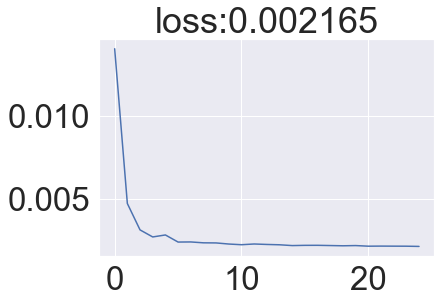

In [80]:
# Combatting overfitting with dropout
from keras.layers import Dropout

# Create model with dropout
model_3 = Sequential()
model_3.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Fit model with mean squared error loss function
model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

In [83]:
# Ensembling models
import numpy as np
# Make predictions from the 3 neural net models
train_pred1 = model_1.predict(scaled_train_features)
test_pred1 = model_1.predict(scaled_test_features)

train_pred2 = model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)

train_pred3 = model_3.predict(scaled_train_features)
test_pred3 = model_3.predict(scaled_test_features)

# Horizontally stack predictions and take the average across rows
train_preds = np.mean(np.hstack((train_pred1, train_pred2, train_pred3)), axis=1)
test_preds = np.mean(np.hstack((test_pred1, test_pred2, test_pred3)), axis=1)
print(test_preds[-5:])

[-0.01226428 -0.00366775 -0.00253637  0.00030451  0.00170646]


0.09527678449114163
-0.12461475316759607


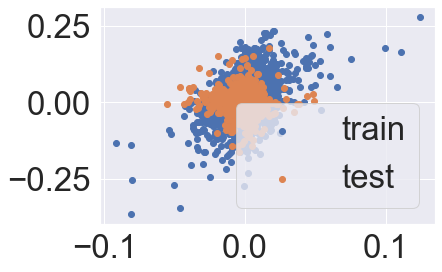

In [84]:
# See how the ensemble performed

from sklearn.metrics import r2_score

# Evaluate the R^2 scores
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend(); plt.show()


# Try LSTM